# Optical Spectrum Classification & Analysis Pipeline
-------
## Overview
This notebook implements an automated pipeline for the classification and analysis of galaxy optical spectra. It distinguishes between various galaxy types—**Star-Forming (SF), Active Galactic Nuclei (AGN: Broad and narrow), LINER, Composite, and Passive**—using machine learning models trained on spectral features.

## Prerequisites & Setup
It is **strongly recommended** to create a dedicated Conda Python environment before running this notebook. This ensures that all necessary libraries (such as Astropy, Scikit-Learn, and Pandas) are installed with the correct versions and prevents conflicts with your existing system packages.

> **Note:** Please refer to the **README** file included in this repository for detailed, step-by-step instructions on how to create and activate the required Conda environment.

## Key Methodologies
The workflow integrates statistical robustness and kinematic analysis through the following steps:

1.  **Probabilistic Classification (Monte Carlo):**
    Instead of a single point-estimate classification, we perform Monte Carlo (MC) simulations. By perturbing the flux within its uncertainty range, we generate a probability distribution for each class, ensuring the classification accounts for spectral noise.
    
2.  **Equivalent Width (EW) Measurement:**
    We calculate the Equivalent Width for key emission lines (**H$\alpha$**, **H$\beta$**, and **[O III]**).  These features are the primary inputs for the diagnostic diagrams (e.g., BPT diagrams) used by the classifier.

3.  **Kinematic Analysis (FWQM):**
    For sources identified as AGN, we further differentiate between **Broad Line** (Type 1) and **Narrow Line** (Type 2) AGN by measuring the *Full Width at Quarter Maximum* (FWQM) of the H$\alpha$ + [N II] line. 

## Dependencies
* **`EW_classifier` (ewc):** A custom module containing the core logic for EW calculation (`calc_eqw_mc`) and random forest classification (`rf_classify_mc`).
* **`Scikit-Learn`:** Used for the pre-trained Support Vector Machine (SVM) and scaler objects.

In [1]:
import os 
import pandas as pd
import numpy as np
import EW_classifier as ewc
import joblib

### 1. Load Pre-trained Classifiers
We load the pre-trained machine learning models and data scalers. 
* **`clf`**: The main classifier (SVM) used to distinguish between major galaxy classes (SF, AGN, LINER, etc.).
* **`scaler_sv`**: The standard scaler used to normalize the input features (Equivalent Widths) to match the training data distribution.
* **`clf_AGN_Type`**: A specialized classifier to distinguish between Broad-line and Narrow-line AGNs based on line widths.
* **`scaler_AGN_Type`**: The standard scaler used to normalize the FWQM to match the training data distribution.

In [2]:
clf = joblib.load('../Models/Auto_OptSepcClassifier_SVM.sav')
scaler_sv = joblib.load('../Models/Auto_OptSepcClassifier_scaler.sav')

In [3]:
scaler_AGN_Type = joblib.load('../Models/Auto_OptSepcClassifier_scaler_AGN_type.sav')
clf_AGN_Type = joblib.load('../Models/Auto_OptSepcClassifier_SVM_AGN_type.sav')

#### Load example spectra for demonstration

In [4]:
path_to_AGN_spec = '../Example data/SDSS_example_spectrum_broad_line_AGN.csv'
path_to_SFG_spec = '../Example data/SDSS_example_spectrum_SFG.csv'

df_csv = pd.read_csv(f'{path_to_SFG_spec}')

flux = df_csv['flux']
wavelength = df_csv['wavelength']
var = df_csv['var']

### 2. Monte Carlo Spectral Classification
We employ the `rf_classify_mc` function to classify the spectrum. This function mitigates the impact of noise by generating multiple synthetic realizations of the spectrum based on the flux errors ($\sigma$).

**Function:** `rf_classify_mc(wavelength, flux, sigma, clf, scaler_sv, plot, n_mc=100)`

* **Mechanism:** Extracts EWs for H$\alpha$, [OIII], and H$\beta$, perturbs them according to measurement errors, and runs the classifier `n_mc` times.
* **Output:** Returns the majority class label. If `plot=True`, it visualizes the probability distribution across all classes.

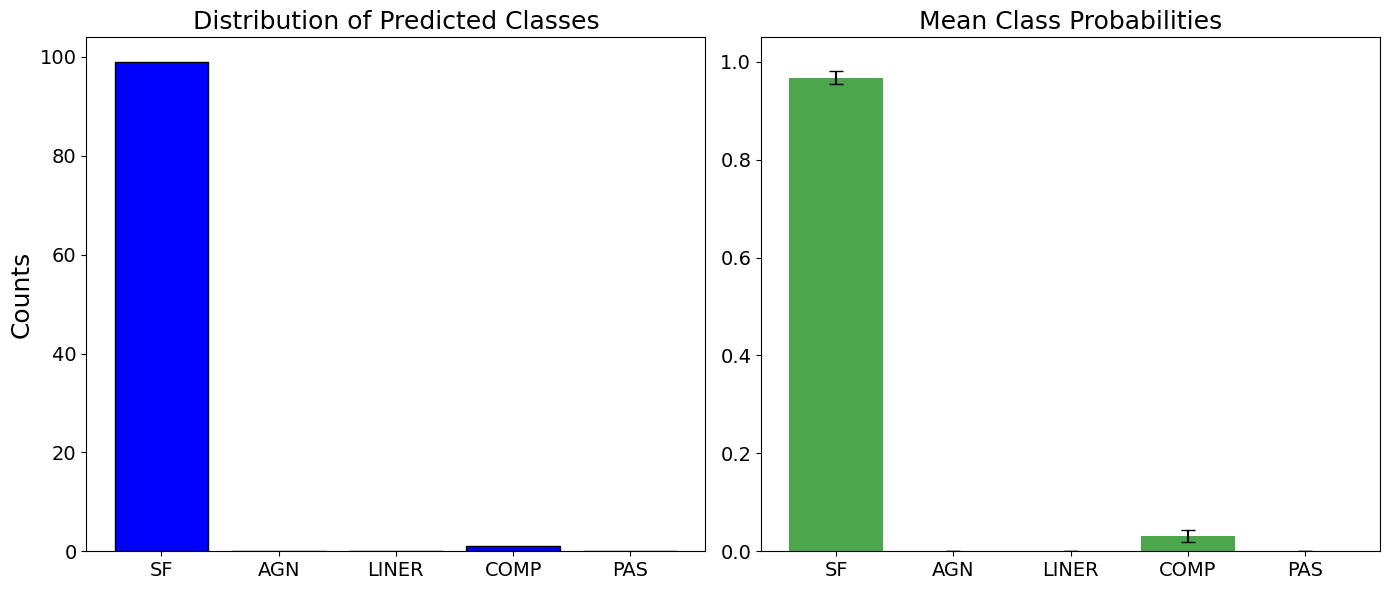

In [5]:
ewc.rf_classify_mc(wavelength, flux, var, clf, scaler_sv, True, n_mc=100)

### 3. Measuring Equivalent Widths (EW) and Estimate Uncertainty
To understand the ionization source of the galaxy, we measure the Equivalent Width of specific diagnostic lines using `calc_eqw_mc`.

**Function:** `calc_eqw_mc(wavelength, flux, sigma, line_center, line_width, cont_width, mc_iter)`

This function isolates the spectral line (e.g., H$\alpha$), fits the local continuum using sidebands, and uses Monte Carlo iterations to estimate the EW and its error.

**Target Lines:**
* **H$\alpha$ + [N II]:** Primary recombination line for star formation rate.
* **[O III] (5007 $\mathring{A}$):** Forbidden line sensitive to the hardness of the ionization field (AGN tracer).
* **H$\beta$ (4864 $\mathring{A}$):** Used alongside [O III] for BPT diagnostics.

In [6]:
EW_Ha_NII, e_EW_Ha_NII = ewc.calc_eqw_mc(wavelength, flux, var, line_center = 6566, line_width = 80, cont_width = 10, mc_iter=100)
print(f'Mean EW of Ha + [NIII]: {EW_Ha_NII:.2f} A,\nSTD EW of Ha + [NIII]: {e_EW_Ha_NII:.2f} A')

Mean EW of Ha + [NIII]: -97.30 A,
STD EW of Ha + [NIII]: 1.17 A


In [7]:
EW_OIII, e_EW_OIII = ewc.calc_eqw_mc(wavelength, flux, var, line_center = 5007, line_width = 30, cont_width = 10, mc_iter=100)
print(f'Mean EW of [OIII]: {EW_OIII:.2f} A,\nSTD EW of [OIII]: {e_EW_OIII:.2f} A')

Mean EW of [OIII]: -9.25 A,
STD EW of [OIII]: 0.49 A


In [8]:
EW_Hb, e_EW_Hb = ewc.calc_eqw_mc(wavelength, flux, var, line_center = 4864, line_width = 30, cont_width = 10, mc_iter=100)
print(f'Mean EW of Hb: {EW_Hb:.2f} A,\nSTD EW of Hb: {e_EW_Hb:.2f} A')

Mean EW of Hb: -10.19 A,
STD EW of Hb: 0.35 A


### 4. Probabilistic Classification
In this step, we run the Monte Carlo classification again, but this time with `plot=False`

**Function:** `rf_classify_mc(..., plot=False, ...)`

Instead of displaying a visual figure, the function returns three key variables:
1.  **`label` (str):** The final predicted class of the galaxy (e.g., 'AGN', 'SF') based on the majority vote of the MC simulations.
2.  **`means` (array):** The average probability for each galaxy class across the $N$ iterations. This tells us how confident the model is in its prediction.
3.  **`stds` (array):** The standard deviation of those probabilities.

In [9]:
label, means, stds = ewc.rf_classify_mc(wavelength, flux, var, clf, scaler_sv, False, n_mc=100)

In [10]:
means

mc_proba_SF       0.967309
mc_proba_AGN      0.000245
mc_proba_LINER    0.000358
mc_proba_COMP     0.032010
mc_proba_PAS      0.000078
dtype: float64

In [11]:
print(f'Classification result (MC majority vote): {label}')

Classification result (MC majority vote): SF


In [12]:
print("Mean deviation of predicted probabilities (%) per class:")
print('------------------------------------')
print((100*means).to_string(float_format="%.2f"))

Mean deviation of predicted probabilities (%) per class:
------------------------------------
mc_proba_SF      96.73
mc_proba_AGN      0.02
mc_proba_LINER    0.04
mc_proba_COMP     3.20
mc_proba_PAS      0.01


In [13]:
print("Standard deviation of predicted probabilities (%) per class:")
print('---------------------------------------')
print((100*stds).to_string(float_format="%.2f"))

Standard deviation of predicted probabilities (%) per class:
---------------------------------------
mc_proba_SF      1.98
mc_proba_AGN     0.01
mc_proba_LINER   0.01
mc_proba_COMP    1.97
mc_proba_PAS     0.00


The classification output can be save to a csv file:

In [14]:
df_label = pd.DataFrame({'label': [label]})
df_means = means.to_frame().T

df_stds = stds.to_frame().T.add_suffix('_std')
final_row = pd.concat([df_label, df_means, df_stds], axis=1)
final_row.to_csv('path-to-file/classification_output.csv', index=False) 

### 5. Kinematic Analysis: Full Width at Quarter Maximum (FWQM)
If the primary classifier identifies the object as an **AGN**, we perform a secondary check. We use the FWQM of the H$\alpha$ line to determine if it is a **Broad Line AGN** (Type 1, viewing the central accretion disk directly) or a **Narrow Line AGN** (Type 2, obscured).
**Function:** `fwqm(flux, wavelength, line)`

* **Metric:** Full Width at Quarter Maximum (FWQM).

In [15]:
FWQM_Ha = ewc.fwqm(flux, wavelength, 'ha')
print(f'FWQM Hb: {FWQM_Ha:.2f} A')

FWQM Hb: 6.24 A


In [16]:
if label == 'AGN':
    features = pd.DataFrame([[FWQM_Ha]], columns=scaler_AGN_Type.feature_names_in_)
    prediction = clf_AGN_Type.predict(scaler_AGN_Type.transform(features))[0]
    if prediction == 1:
        print("Narrow Line AGN")
    else:
        print("Broad Line AGN")
else:
    print(label)

SF


### 6. Contamination From or Outflows
In some cases, the broadening of H$\alpha$ may be the result of shocks or outflows. Depending on the individual case, it is advised to compare the broadening of a forbidden line (e.g., [O III]) to that of a Balmer line (e.g., H$\alpha$).

The automated way:

In [17]:
ewc.check_fwqm_ratio(flux, wavelength)

'Normal'

Manual check:

In [18]:
FWQM_Hb = ewc.fwqm(flux, wavelength, 'hb')
print(f'FWQM Hb: {FWQM_Hb:.2f} A')

FWQM Hb: 4.32 A


In [19]:
FWQM_OIII = ewc.fwqm(flux, wavelength, 'oiii')
print(f'FWQM OIII: {FWQM_OIII:.2f} A')

FWQM OIII: 4.54 A


In [20]:
# EOF